In [1]:
%pylab inline
%load_ext Cython
%load_ext wurlitzer

import geomalgo as ga

Populating the interactive namespace from numpy and matplotlib


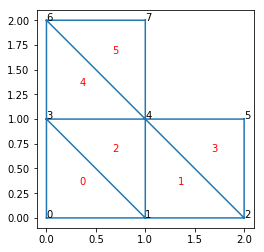

In [2]:
x = array([0, 1, 2, 0, 1, 2, 0, 1], dtype='d')
y = array([0, 0, 0, 1, 1, 1, 2, 2], dtype='d')
trivtx = array([[0, 1, 3], [1, 2, 4], [1, 4, 3], [2, 5, 4],
                [3, 4, 6], [4, 7, 6]], dtype='int32')

def plot_with_indices():
    # Plot triangulation.
    triplot(x, y, trivtx)

    # Plot vertices indices.
    for ivert, (xvert, yvert) in enumerate(zip(x, y)):
        text(xvert, yvert, ivert)

    # Plot triangle indices.
    for itri, (v0, v1, v2) in enumerate(trivtx):
        xcenter = (x[v0] + x[v1] + x[v2]) / 3.
        ycenter = (y[v0] + y[v1] + y[v2]) / 3.
        text(xcenter, ycenter, itri, color='red')

    axis('scaled')
    show()
    
plot_with_indices()

In [3]:
print(trivtx[2])

[1 4 3]


In [4]:
TG = ga.Triangulation2D(x, y, trivtx)              

In [5]:
%%cython

from libc.stdio cimport printf
cimport geomalgo as ga

def iter_triangles(ga.Triangulation2D TG):
    cdef:
        int T
        ga.CTriangle2D ABC
        ga.CPoint2D A, B, C

    ga.triangle2d_set(&ABC, &A, &B, &C)

    for T in range(TG.NT):
        TG.get(T, &ABC)
        printf("%d: A(%.0f,%.0f), B(%.0f,%.0f), C(%.0f,%.0f)\n",
               T, A.x, A.y, B.x, B.y, C.x, C.y)

In [6]:
iter_triangles(TG)

0: A(0,0), B(1,0), C(0,1)
1: A(1,0), B(2,0), C(1,1)
2: A(1,0), B(1,1), C(0,1)
3: A(2,0), B(2,1), C(1,1)
4: A(0,1), B(1,1), C(0,2)
5: A(1,1), B(1,2), C(0,2)


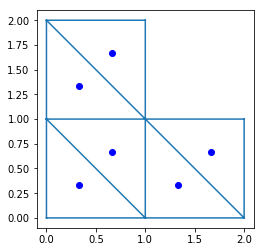

In [7]:
triplot(x, y, trivtx)

xcenter, ycenter = ga.triangulation.compute_centers(TG)

plot(xcenter, ycenter, 'bo')

axis('scaled')
show()

In [8]:
intern_edges, boundary_edges, edge_map = ga.build_edges(TG.trivtx, TG.NV)

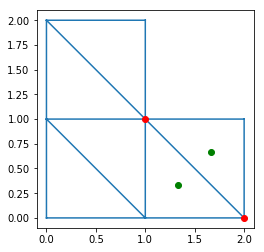

In [9]:
triplot(x, y, trivtx)
I = 2

IA = intern_edges.vertices[I, 0]
IB = intern_edges.vertices[I, 1]
plot([x[IA], x[IB]],
     [y[IA], y[IB]], 'ro')

T0 = intern_edges.triangles[I, 0]
T1 = intern_edges.triangles[I, 1]
plot([xcenter[T0], xcenter[T1]],
     [ycenter[T0], ycenter[T1]], 'go')

axis('scaled')
show()

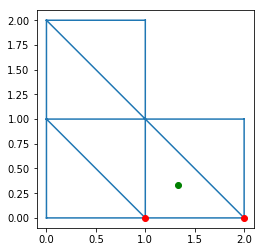

In [10]:
triplot(x, y, trivtx)
I = 2

IA = boundary_edges.vertices[I, 0]
IB = boundary_edges.vertices[I, 1]
plot([x[IA], x[IB]],
     [y[IA], y[IB]], 'ro')

T = boundary_edges.triangle[I]
plot(xcenter[T], ycenter[T], 'go')

axis('scaled')
show()

In [11]:
%%cython

from libc.stdio cimport printf
cimport geomalgo as ga

def find_edge(ga.EdgeMap edge_map, int IA, int IB):
    cdef:
        bint found
        int E, I
        
    E = edge_map.search_edge_idx(IA, IB, &found)
    
    if not found:
        printf("No such edge: (%d,%d)\n", IA, IB)
        return
        
    I = edge_map.idx[E]
        
    if edge_map.location[E] == ga.INTERN_EDGE:
        printf("Intern edge for (%d,%d): %d\n", IA, IB, I)
    else:
        printf("Boudnary edge for (%d,%d): %d\n", IA, IB, I)

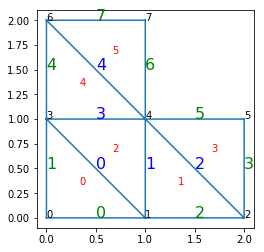

Intern edge for (1,4): 1
Boudnary edge for (7,6): 7
No such edge: (7,5)


In [12]:
def text_middle(IA, IB, color):
    A = ga.Point2D(x[IA], y[IA])
    B = ga.Point2D(x[IB], y[IB])
    AB = ga.Segment2D(A, B)
    M = AB.compute_middle()
    text(M.x, M.y, I, color=color, size=16)

for I in range(boundary_edges.size):
    IA, IB = boundary_edges.vertices[I]
    text_middle(IA, IB, 'green')
    
for I in range(intern_edges.size):
    IA, IB = intern_edges.vertices[I]
    text_middle(IA, IB, 'blue')

plot_with_indices()

find_edge(edge_map, 1, 4)
find_edge(edge_map, 7, 6)
find_edge(edge_map, 7, 5)

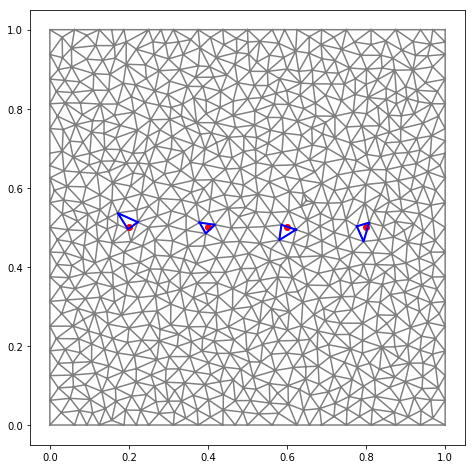

In [13]:
import triangle

def generate_triangulation():
    A = {'vertices' : array([[0,0], [1,0], [1, 1], [0, 1]])}
    B = triangle.triangulate(A, 'qa0.001')
    return ga.Triangulation2D(B['vertices'][:,0],
                              B['vertices'][:,1],
                              B['triangles'])
TG = generate_triangulation()

xpoints = np.array([0.2, 0.4, 0.6, 0.8])
ypoints = np.array([0.5, 0.5, 0.5, 0.5])

locator = ga.TriangulationLocator(TG, nx=4, ny=4)
triangles = locator.search_points(xpoints, ypoints)

fig = figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)                                                      
triplot(TG.x, TG.y, TG.trivtx, color='gray')
plot(xpoints, ypoints, 'ro')
for T in triangles:
    TG[T].plot()
axis('scaled')
show()

(2, 3)
(2, 3)
nx, ny = 1, celltri size: 2, celltri_idx size: 1539
nx, ny = 2, celltri size: 5, celltri_idx size: 1679
nx, ny = 4, celltri size: 17, celltri_idx size: 1951
nx, ny = 8, celltri size: 65, celltri_idx size: 2532
nx, ny = 16, celltri size: 257, celltri_idx size: 3953
nx, ny = 32, celltri size: 1025, celltri_idx size: 7682


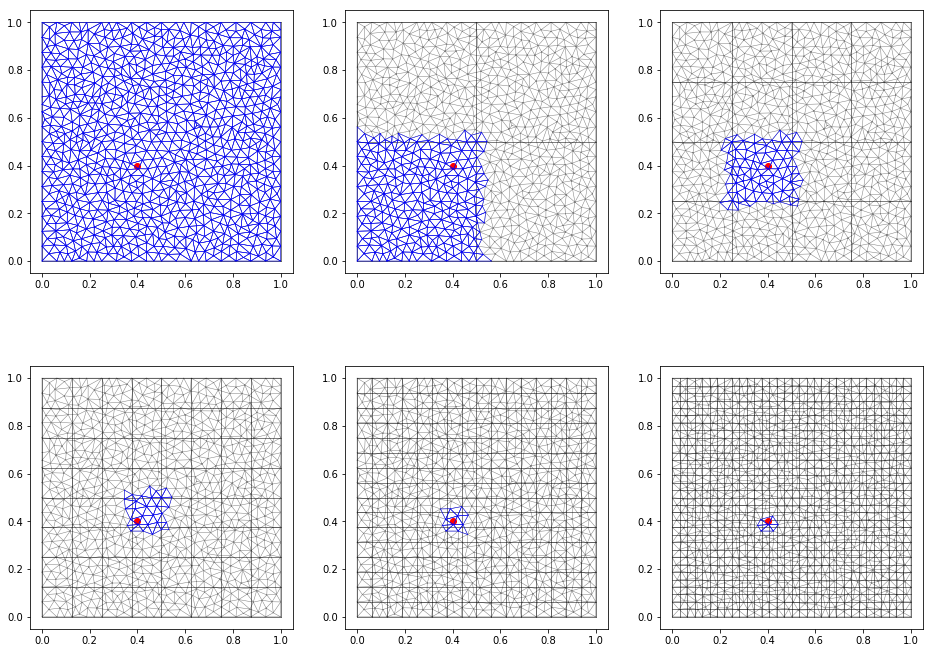

In [15]:
cell_numbers = array([[1,  2,  4], [8, 16, 32]])

nrows = cell_numbers.shape[0]
ncols = cell_numbers.shape[1]
fig, axes = subplots(ncols=3, nrows=2, figsize=(16,12))

print(cell_numbers.shape)
print(axes.shape)

for irow in range(nrows):
    for icol in range(ncols):
        n = cell_numbers[irow, icol]
        fig.sca(axes[irow, icol])

        triplot(TG.x, TG.y, TG.trivtx, color='gray', lw=0.5)

        locator = ga.TriangulationLocator(TG, nx=n, ny=n)
        locator.grid.plot(color='black', lw=0.5)

        P = ga.Point2D(0.4, 0.4)
        P.plot(color='red')

        cell = locator.grid.find_cell(P)

        for T in locator.cell_to_triangles(cell.ix, cell.iy):
            TG[T].plot(lw=0.5)

        print("nx, ny = {}, celltri size: {}, celltri_idx size: {}".format(
                  n, len(locator.celltri), len(locator.celltri_idx)))

        axis('scaled')
show()